In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
from model import *

In [3]:
from dataset import get_data_loader
from torchvision import transforms
from utils import ScaleImageByHeight
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import ImageGrid
import skimage
import math
from PIL import ImageOps

In [4]:
device = 'cuda:0'
CKPT = 'runs/02-04-2020_15-16-38_tf_vnondb_resnet18_scale64_randrotation10/weights/BEST.pt'

print('Device = {}'.format(device))
print('Load weight from {}'.format(CKPT))
checkpoint = torch.load(CKPT, map_location=device)
root_config = checkpoint['config']

config = root_config['common']

image_transform = transforms.Compose([
    ImageOps.invert,
    ScaleImageByHeight(config['scale_height']),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
])

test_loader = get_data_loader(config['dataset'], 'test', 8,
                              1,
                              image_transform)
vocab = test_loader.dataset.vocab
print('Vocab size = {}'.format(vocab.size))

if config['cnn'] == 'densenet':
    cnn_config = root_config['densenet']
    cnn = DenseNetFE('densenet161', True)
elif config['cnn'] == 'squeezenet':
    cnn = SqueezeNetFE()
elif config['cnn'] == 'efficientnet':
    cnn = EfficientNetFE('efficientnet-b1')
elif config['cnn'] == 'custom':
    cnn = CustomFE(3)
elif config['cnn'] == 'resnet':
    cnn = ResnetFE('resnet18')
else:
    raise ValueError('Unknow CNN {}'.format(config['cnn']))

model_config = root_config['tf']
model = ModelTF(cnn, vocab, model_config)
model.to(device)
model.load_state_dict(checkpoint['model'])

print('Ok')

Device = cuda:0
Load weight from runs/02-04-2020_15-16-38_tf_vnondb_resnet18_scale64_randrotation10/weights/BEST.pt
Vocab size = 147
Ok


In [5]:
named_modules = {}
def hook_weight_fn(module, inputs, outputs):
    named_modules[module]['output'] = outputs[1].cpu()

feature_size = tuple()
def hook_feature_size(module, inputs, outputs):
    global feature_size
    feature_size = outputs.shape

for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        named_modules[module] = {
            'name': name,
            'output': None,
        }
        module.register_forward_hook(hook_weight_fn)
    elif isinstance(module, (ResnetFE, DenseNetFE)):
        module.register_forward_hook(hook_feature_size)


In [6]:
print(model)

ModelTF(
  (cnn): ResnetFE(
    (cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momen

In [7]:
iter_test_loader = iter(test_loader)

In [22]:
model.eval()
with torch.no_grad():
    batch = next(iter_test_loader)
    imgs, targets = batch.images.to(device), batch.labels.to(device)
    outputs = model.greedy(imgs, targets[:,0], 150)
    outputs, targets = outputs, targets[:, 1:]
    outputs = outputs.cpu()
    targets = targets.cpu()

torch.Size([8, 512, 2, 5])


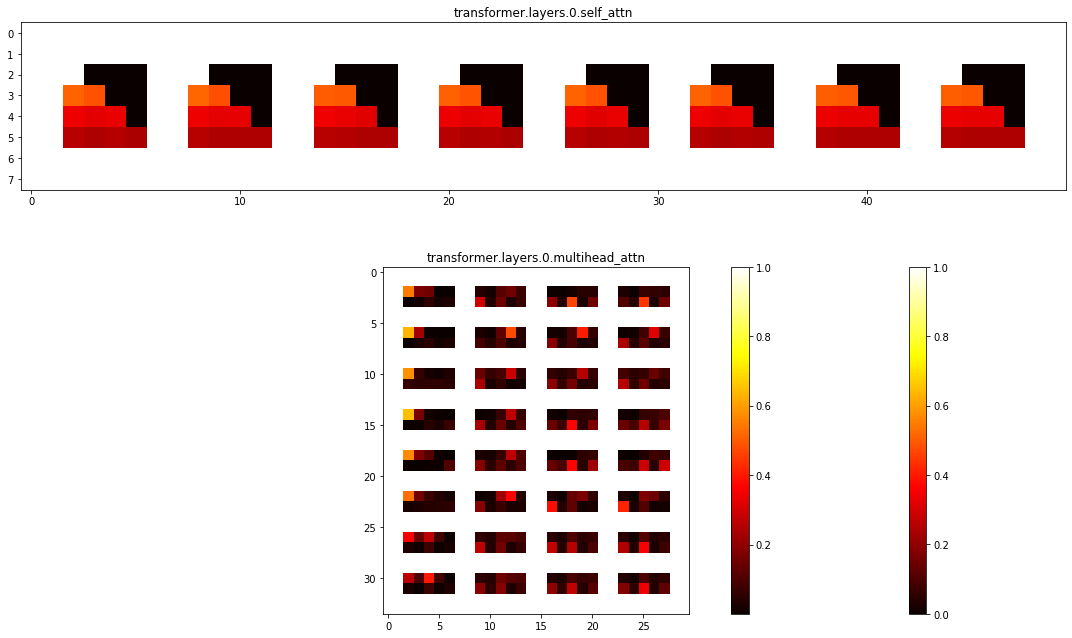

In [36]:
figure, axes = plt.subplots(len(named_modules), 1, squeeze=False, figsize=(15,10))
print(feature_size)
h, w = feature_size[-2:]

for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    axes[i, 0].set_title(title)
    if title.split('.')[-1] == 'multihead_attn':
        weight = weight.reshape(-1, 1, h, w)
        weight_image = torchvision.utils.make_grid(weight, nrow=value['output'].size(1), pad_value=1.)
    else:
        weight = weight.unsqueeze(1)
        weight_image = torchvision.utils.make_grid(weight, nrow=8, pad_value=1.)
    img = axes[i, 0].imshow(weight_image[0], cmap='hot')
    plt.colorbar(img, use_gridspec=True)
plt.tight_layout()
plt.show()
    

torch.Size([8, 512, 2, 5])
torch.Size([8, 4, 10])


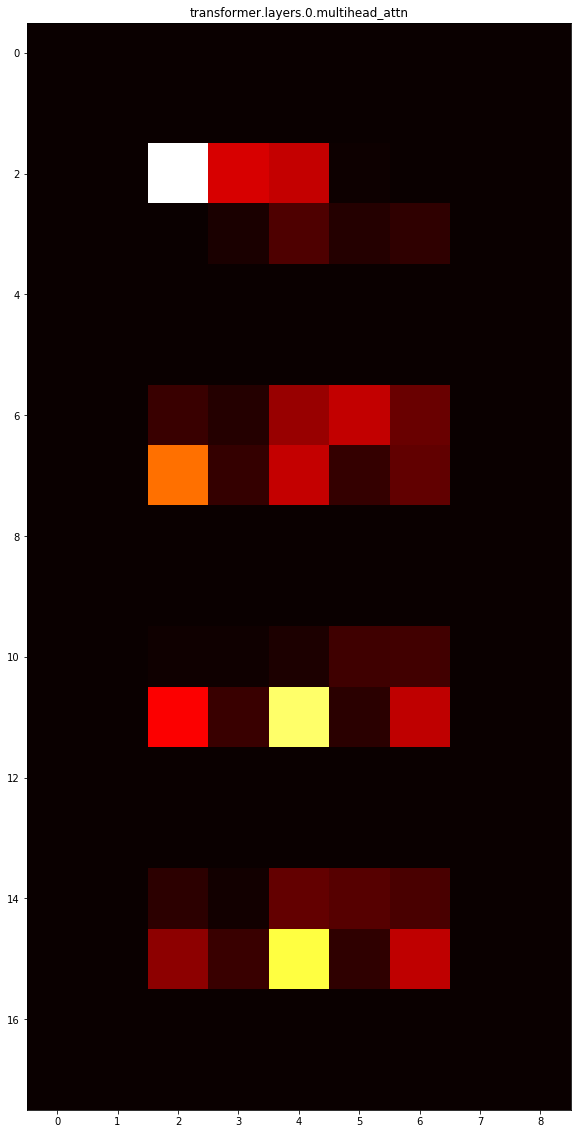

In [24]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,20))
print(feature_size)
h, w = feature_size[-2:]

for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.split('.')[-1] == 'multihead_attn':
        axes[0, 0].set_title(title)
        print(weight.shape)
        weight = weight[0] # get first sample
        weight = weight.reshape(-1, 1, h, w)
        # print(weight.shape)
        weight_image = torchvision.utils.make_grid(weight, nrow=1, pad_value=0)
        # print(weight_image.shape)
        # axes[0, 0].imshow(weight_image.permute(1,2,0), cmap='spring')
        axes[0, 0].imshow(weight_image[0], cmap='hot')

plt.show()
    

torch.Size([8, 512, 2, 7])
torch.Size([6, 1, 2, 7])


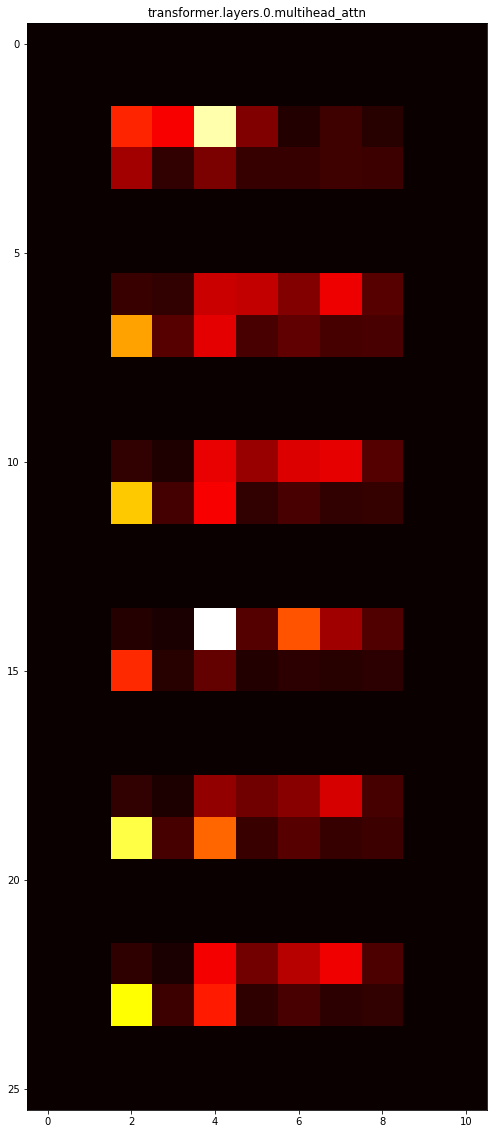

In [26]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,20))
print(feature_size)
h, w = feature_size[-2:]

for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.split('.')[-1] == 'multihead_attn':
        axes[0, 0].set_title(title)
        weight = weight[1] # get first sample
        weight = weight.reshape(-1, 1, h, w)
        print(weight.shape)
        weight_image = torchvision.utils.make_grid(weight, nrow=1, pad_value=0)
        # print(weight_image.shape)
        # axes[0, 0].imshow(weight_image.permute(1,2,0), cmap='spring')
        axes[0, 0].imshow(weight_image[0], cmap='hot')

plt.show()
    

torch.Size([8, 512, 2, 7])
torch.Size([3, 26, 11])


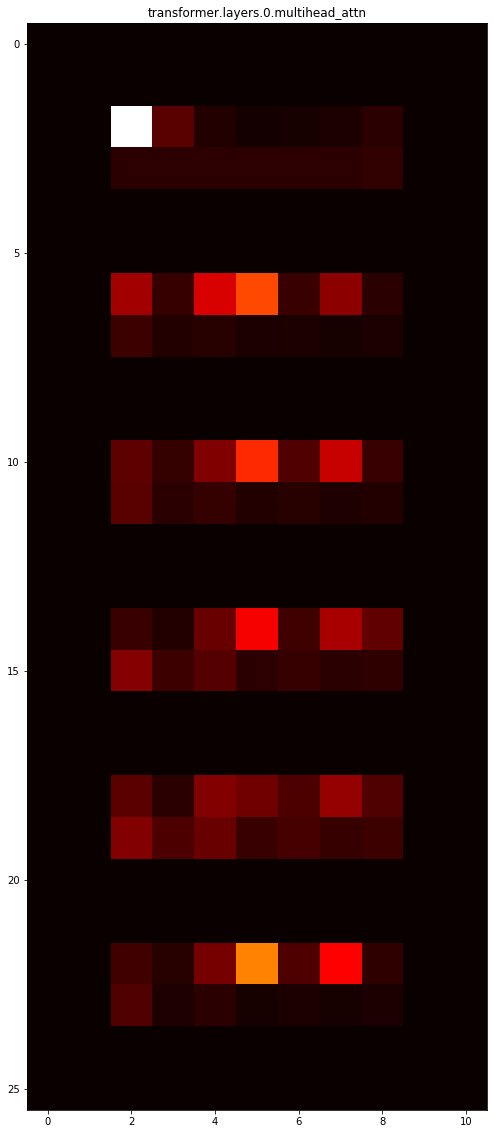

In [18]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,20))
print(feature_size)
h, w = feature_size[-2:]

for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.split('.')[-1] == 'multihead_attn':
        axes[0, 0].set_title(title)
        weight = weight[2] # get first sample
        weight = weight.reshape(-1, 1, h, w)
        # print(weight.shape)
        weight_image = torchvision.utils.make_grid(weight, nrow=1, pad_value=0)
        print(weight_image.shape)
        # axes[0, 0].imshow(weight_image.permute(1,2,0), cmap='spring')
        axes[0, 0].imshow(weight_image[0], cmap='hot')

plt.show()
    

torch.Size([8, 512, 2, 7])
torch.Size([3, 26, 11])


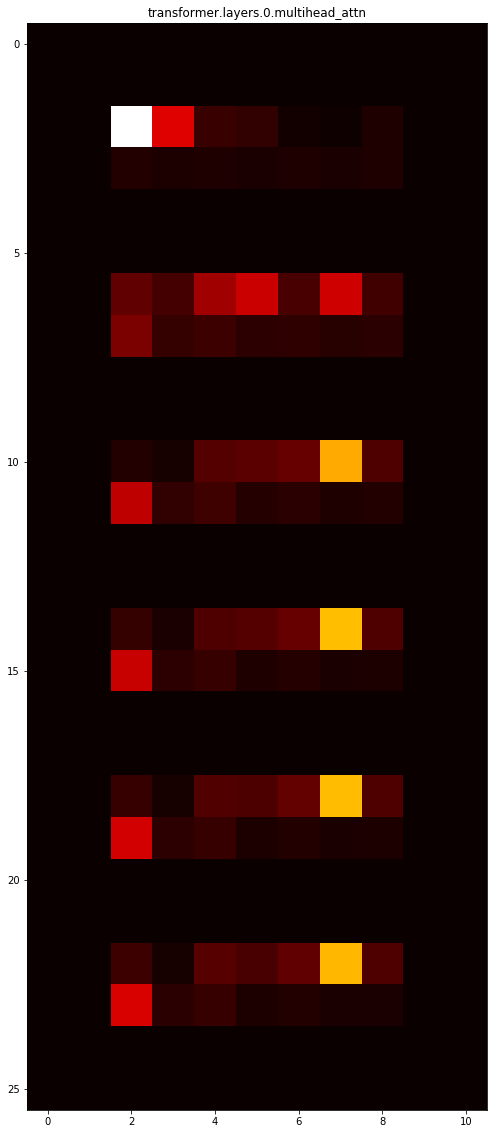

In [19]:
figure, axes = plt.subplots(1, 1, squeeze=False, figsize=(15,20))
print(feature_size)
h, w = feature_size[-2:]

for i, (key, value) in enumerate(named_modules.items()):
    title = value['name']
    weight = value['output']
    if title.split('.')[-1] == 'multihead_attn':
        axes[0, 0].set_title(title)
        weight = weight[3] # get first sample
        weight = weight.reshape(-1, 1, h, w)
        # print(weight.shape)
        weight_image = torchvision.utils.make_grid(weight, nrow=1, pad_value=0)
        print(weight_image.shape)
        # axes[0, 0].imshow(weight_image.permute(1,2,0), cmap='spring')
        axes[0, 0].imshow(weight_image[0], cmap='hot')

plt.show()
    